In [11]:
import pandas as pd
import io
import requests
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from datetime import datetime, timedelta

# Pipeline Goal
1. Download Dataset from the website for our specified date/source period
2. Put into panda dataset for easy manipulation
3. Plot Data (ensure it works)
4. Data Manipulation
    a. Set Threshold value
    b. Get rid of 

## Putting Dataset into Pandas

In [2]:
columns = ["Year", "Day", "Hour", "DSCOV Bz_gse, nT", "WIND Bz_gse, nT" , "ACE Bz_gse, nT"]

file_path = "data/readings.lst"
df = pd.read_csv(file_path, sep = "\s+", header=None, names= columns)
df.head()

,Year,Day,Hour,"DSCOV Bz_gse, nT","WIND Bz_gse, nT","ACE Bz_gse, nT"
0,2016,156,0,999.9,-0.1,0.4
1,2016,156,1,1.1,1.1,1.1
2,2016,156,2,0.4,0.3,0.6
3,2016,156,3,0.3,0.1,-0.1
4,2016,156,4,-1.0,0.0,-0.6


In [3]:
# merge Year Day hour into one column
df["Date-Time"] = pd.to_datetime(df[["Year", "Day", "Hour"]].astype(str).agg('-'.join, axis=1), format="%Y-%j-%H")
df.set_index('Date-Time', inplace=True)
df.head()

,Year,Day,Hour,"DSCOV Bz_gse, nT","WIND Bz_gse, nT","ACE Bz_gse, nT"
Date-Time,,,,,,
2016-06-04 00:00:00,2016,156,0,999.9,-0.1,0.4
2016-06-04 01:00:00,2016,156,1,1.1,1.1,1.1
2016-06-04 02:00:00,2016,156,2,0.4,0.3,0.6
2016-06-04 03:00:00,2016,156,3,0.3,0.1,-0.1
2016-06-04 04:00:00,2016,156,4,-1.0,0.0,-0.6


In [4]:
# Remove all 999.99, replace with NaN
df.loc[df["DSCOV Bz_gse, nT"] == 999.9, "DSCOV Bz_gse, nT"] = None
df.loc[df["WIND Bz_gse, nT"] == 999.9, "WIND Bz_gse, nT"] = None
df.loc[df["ACE Bz_gse, nT"] == 999.9, "ACE Bz_gse, nT"] = None

df.head()

,Year,Day,Hour,"DSCOV Bz_gse, nT","WIND Bz_gse, nT","ACE Bz_gse, nT"
Date-Time,,,,,,
2016-06-04 00:00:00,2016,156,0,NaN,-0.1,0.4
2016-06-04 01:00:00,2016,156,1,1.1,1.1,1.1
2016-06-04 02:00:00,2016,156,2,0.4,0.3,0.6
2016-06-04 03:00:00,2016,156,3,0.3,0.1,-0.1
2016-06-04 04:00:00,2016,156,4,-1.0,0.0,-0.6


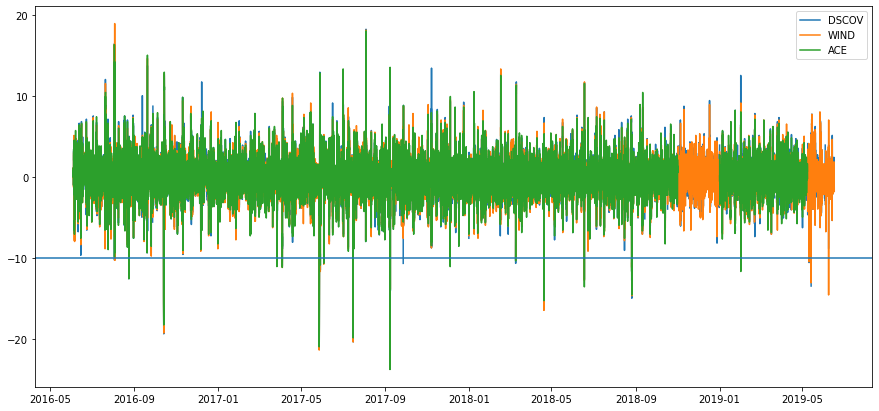

In [5]:
plt.figure(figsize=(15, 7))
plt.plot(df["DSCOV Bz_gse, nT"], label = "DSCOV")
plt.plot(df["WIND Bz_gse, nT"], label = "WIND")
plt.plot(df["ACE Bz_gse, nT"], label = "ACE")

plt.axhline(y=-10)
plt.legend()
plt.show()

### Putting ACE dataset into pandas 

In [14]:
columns_ACE = ["Year", "Day", "Hour", "ACE Bx_gse, nT", "ACE By_gse, nT" , "ACE Bz_gse, nT"]

file_path = "data/ACE/readings_ACE.lst"
df_ACE = pd.read_csv(file_path, sep = "\s+", header=None, names= columns_ACE)

#Combine Year, day, and hour
def CombinedDate(year, day_number, hour):
    date_format = '%Y-%m-%d-%H'
    start_date = datetime(year, 1, 1, 0)                                # create a datetime object for January 1st midnight of the given year
    result_date = start_date + timedelta(days=day_number-1, hours=hour) # add the number of days and hours to the start date
    return result_date.strftime(date_format)                            # format the date string using the specified format and retur it

date_ACE = []

for index in df_ACE.index:
    date_ACE.append(CombinedDate(int(df_ACE['Year'][index]), int(df_ACE['Day'][index]), int(df_ACE['Hour'][index])))

df_ACE.insert(0, "Date", date_ACE, True)    #inserting dates

# Remove all 999.99, replace with NaN
df_ACE['ACE Bx_gse, nT'].replace(999.9, None, inplace=True)
df_ACE['ACE By_gse, nT'].replace(999.9, None, inplace=True)
df_ACE['ACE Bz_gse, nT'].replace(999.9, None, inplace=True)

df_ACE.head()


,Date,Year,Day,Hour,"ACE Bx_gse, nT","ACE By_gse, nT","ACE Bz_gse, nT"
0,1998-02-05-00,1998,36,0,None,None,None
1,1998-02-05-01,1998,36,1,13.4,0.1,3.1
2,1998-02-05-02,1998,36,2,13.2,0.1,3.5
3,1998-02-05-03,1998,36,3,12.3,-1.6,4.7
4,1998-02-05-04,1998,36,4,11.8,-0.8,5.6


### PLotting ACE Dataset: Raw data, Fourier transform of all 3 vector components, spectral analysis of the z-component vector

In [15]:
# Create figure
fig_ACE_raw = go.Figure()

fig_ACE_raw.add_trace(
    go.Scatter(x=list(df_ACE.Date), y=list(df.High)))

# Set title
fig.update_layout(
    title_text="Time series with range slider and selectors"
)

# Add range slider
fig.update_layout(
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1,
                     label="1m",
                     step="month",
                     stepmode="backward"),
                dict(count=6,
                     label="6m",
                     step="month",
                     stepmode="backward"),
                dict(count=1,
                     label="YTD",
                     step="year",
                     stepmode="todate"),
                dict(count=1,
                     label="1y",
                     step="year",
                     stepmode="backward"),
                dict(step="all")
            ])
        ),
        rangeslider=dict(
            visible=True
        ),
        type="date"
    )
)

fig.show()

AttributeError: 'DataFrame' object has no attribute 'High'

# Visualization

- Look at plotting average, median, range
- How many are NaN, etc

# Thresholding
Thresholding, and oogabooga, average time based on threshold

In [7]:
df2 = df.copy()

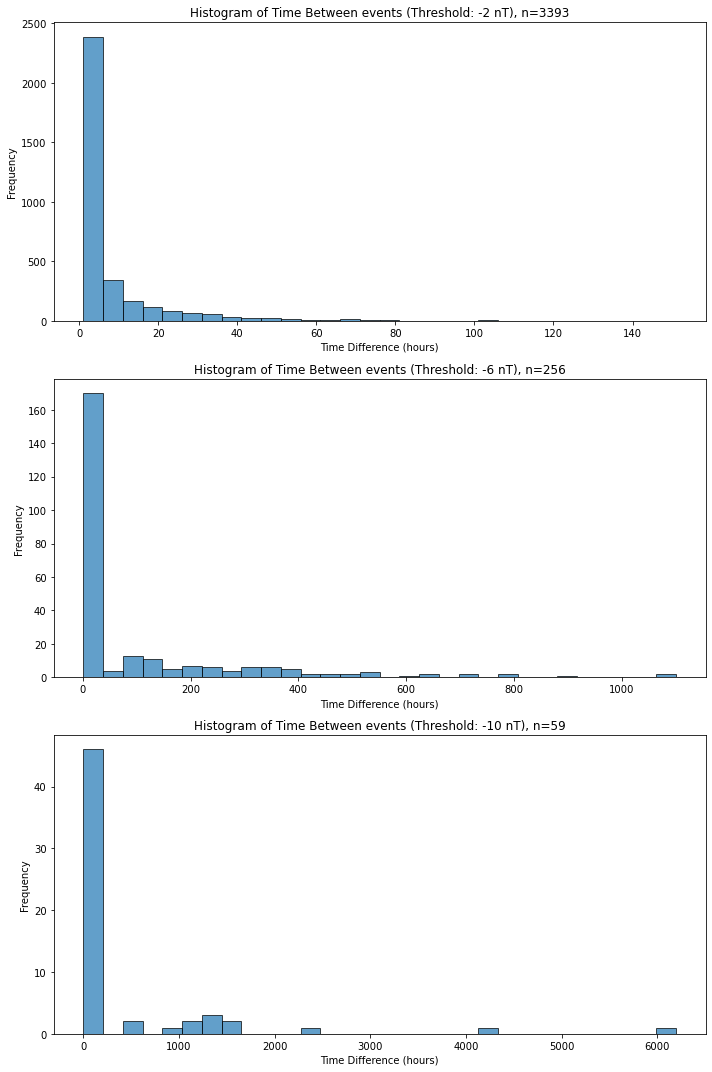

In [8]:
thresholds = [-2, -6, -10] #in nT

fig, axs = plt.subplots(len(thresholds), figsize=(10, 5*len(thresholds)))
for i, threshold in enumerate(thresholds):
    DSCOV_IMF_times = df2.index[ df2["DSCOV Bz_gse, nT"] <= threshold]
    DSCOV_IMF_time_diffs = DSCOV_IMF_times[1:] - DSCOV_IMF_times[:-1]
    # print("Number of IMF below {threshold} nT threshold: ", len(DSCOV_IMF_time_diffs))

    DSCOV_IMF_time_diffs_hrs = DSCOV_IMF_time_diffs.total_seconds() / 3600  
    axs[i].hist(DSCOV_IMF_time_diffs_hrs, bins=30, edgecolor='k', alpha=0.7)
    axs[i].set_title(f'Histogram of Time Between events (Threshold: {threshold} nT), n={len(DSCOV_IMF_time_diffs)}')
    axs[i].set_xlabel('Time Difference (hours)')
    axs[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

[]

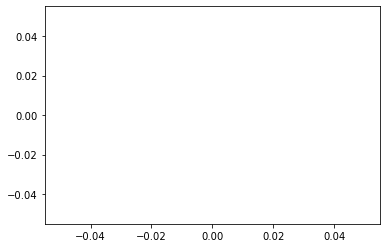

In [9]:
DSCOV_IMF_times = df2.index[ df2["DSCOV Bz_gse, nT"] < -6]
plt.plot()

# Research


In [10]:
#threshold: -10nT --> https://www.spaceweatherlive.com/en/help/the-interplanetary-magnetic-field-imf.html
# when DSCOVR B > 25nT: sm WIND measurements are significantly smaller. 
# ACE & Wind are universally consistent, we suggest using ACE or Wind measurement of the
# magnetic field when the apparent field strength from DSCOVR is above 25nT

# lists of dates of CME (coronal mass ejection) --> we can determine the threshold using that
